# outline of 'Revealing non-canonical RNA interactions in DMS chemical mapping'

## Extra resources
current draft: https://uofnelincoln-my.sharepoint.com/:w:/r/personal/jyesselman2_unl_edu/_layouts/15/Doc.aspx?sourcedoc=%7B2AAE1849-B2EB-44FC-8A5F-1ED79D0654BC%7D&file=draft_9.docx&action=default&mobileredirect=true

## Notebook setup
NOTE: all data is assumed to be in '../data' and this notebook will not work if the data is in another location!

In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import plot_pop_avg_from_row, publication_style_ax, plot_motif_boxplot_stripplot, plot_scatter_w_best_fit_line
from dms_3d_features.pdb_features import compute_solvent_accessibility_all

plt.rcParams['figure.dpi'] = 150


In [2]:
DATA_PATH = "../data"

In [3]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json")
df_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json")
df_motif = pd.read_json(f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json")
df_residue = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [4]:
df_residue["ln_r_data"] = np.log(df_residue["r_data"])
df_residue['ln_r_data'].replace(-np.inf, -9.8, inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
df.iloc[0]

name                                                construct750
sequence       AGACUACCCAUAAAGGUUAUUGCGAGCUAUUAAACGUCCACAGUUA...
structure      .((((..(((((..(((((..(((((..(((((..(((((..((((...
data           [0.00523, 0.00124, 0.0038, 0.00289, 0.00047000...
sn                                                         11.21
num_reads                                                  59978
num_aligned                                                59924
no_mut                                                     50.09
1_mut                                                      34.73
2_mut                                                      11.98
3_mut                                                       2.66
3plus_mut                                                   0.06
mfe                                                        -55.6
ens_defect                                                  0.62
Name: 0, dtype: object

## Introduction

### Why is chemical mapping important?

Structured RNA is pivotal in fundamental biological processes such as protein translation, mRNA maturation, and telomere repair (1-3). To perform these processes, RNA must fold into complex base-paired secondary and tertiary structures. In recent years, there has been rapid growth in probing these structures using chemical mapping experiments (XXX cite rouskin, mustoe, lucks, qi zhang and our other papers XXX). These experiments utilize small molecule regents that can chemically modify the structure of nucleotides based on its local environment. Recently, these methods have been coupled to next-generation sequencing techniques that have exploded the amount that can be collected in single runs, that can span entire transcriptomes or probe hundreds of rationally designed RNAs. Given the ease of these methods they are often included in most study of RNA structure and function and are increasingly becoming part of the standard toolkit of studying RNA.  

### Why DMS and why continue to improve methods using it?

## Results

### Designing a massive RNA library to investigate the relationship between DMS reactivity and non-canonical interactions.  

### DMS reactivity is highly reproducible and spans five orders of magnitude. 

#### highest and lowest dms values

In [28]:
lowest_non_zero_value = df_residue[df_residue['r_data'] != 0]['r_data'].min()
print("min val: ", lowest_non_zero_value)
print("max val: ", df_residue['r_data'].max())
print("count: ", len(df_residue))

min val:  6.000000000000001e-05
max val:  0.5006900000000001
count:  237528


#### Figure 1B: example data from a single RNA

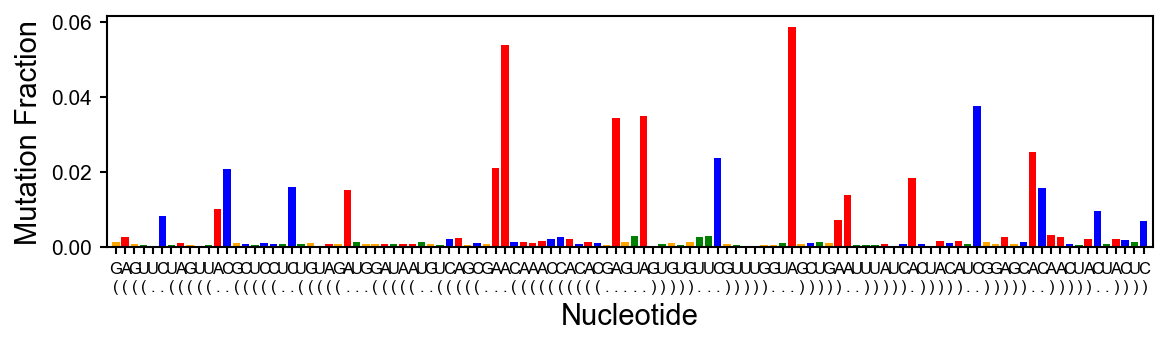

In [25]:
row = df.iloc[7000].to_dict()
row["sequence"] = row["sequence"][1:]
row["structure"] = row["structure"][1:]
row["data"] = row["data"][1:]
fig, ax = plt.subplots(figsize=(9.00, 2.0))
ax = plot_pop_avg_from_row(row, ax=ax)
ax.set_xlabel("Nucleotide")
ax.set_ylabel("Mutation Fraction")
ax.set_xlim(-1, 112)
publication_style_ax(ax, xtick_size=8)

#### Figure 1C: comparision between replicates

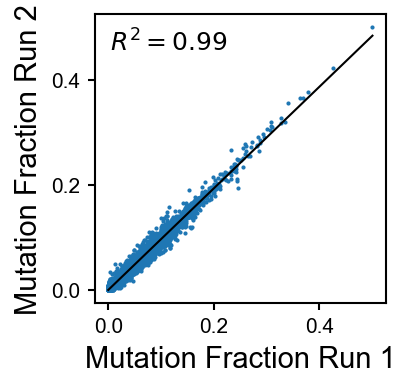

In [26]:
df_2_sub = df_2[["name", "data"]].copy()
df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
df_merge = df.merge(df_2_sub, on="name")

data = []
for i, row in df_merge.iterrows():
    for d1, d2 in zip(row["data"], row["data_2"]):
        data.append({"data_1": d1, "data_2": d2})
df_data = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mutation Fraction Run 1")
ax.set_ylabel("Mutation Fraction Run 2")
publication_style_ax(ax)

#### Figure 1D: histogram of DMS reactivity in Ln space

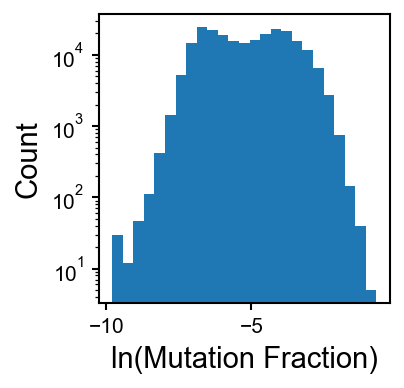

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.hist(df_residue['ln_r_data'], bins=25);
plt.yscale('log')
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_ylabel("Count")
publication_style_ax(ax)

#### Figure 1E: motif count

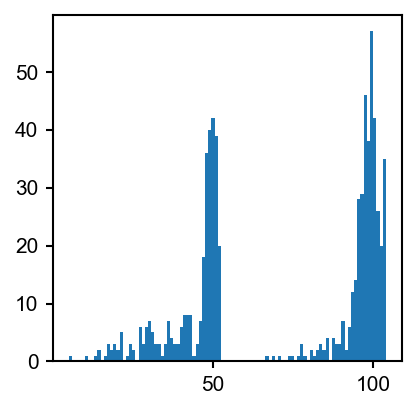

In [30]:
data = []
for i, group in df_motif.groupby("m_sequence"):
    data.append([i, len(group)])
df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])

fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(df_counts["count"], bins=100);
publication_style_ax(ax)

#### Figure 1F: motif example

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:375: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


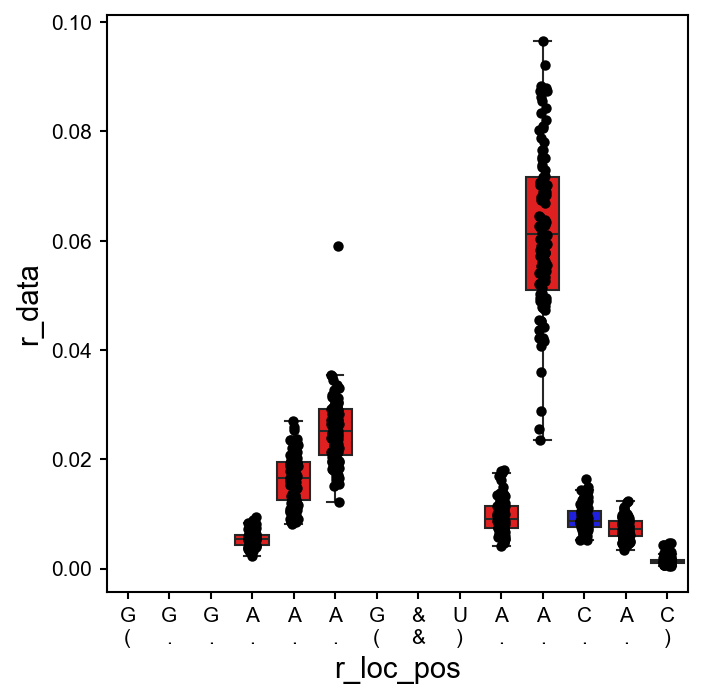

In [40]:
df_motif_example = df_residue[df_residue["m_sequence"] == "GGGAAAG&UAACAC"]
fig, ax = plt.subplots(figsize=(5, 5))
plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
publication_style_ax(ax)

#### Figure 1G: avg vs std dev of DMS reactivity

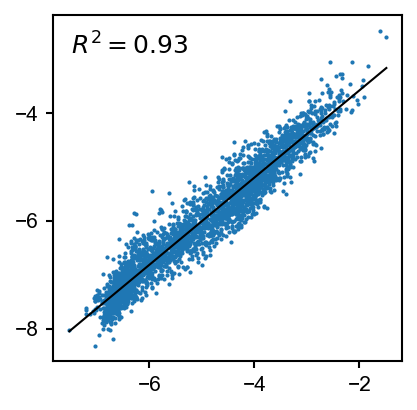

In [41]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    data.append([group["r_data"].mean(), group["r_data"].std()])
df_data = pd.DataFrame(data, columns=["mean", "std"])   

fig, ax = plt.subplots(figsize=(3, 3))
plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
publication_style_ax(ax)

#### Potential Supplemental figures?

##### How many aligns were there?

In [15]:
df["num_aligned"].describe()

count      7500.000000
mean      37688.644133
std       26941.748951
min         369.000000
25%       19796.750000
50%       31129.000000
75%       48240.500000
max      421216.000000
Name: num_aligned, dtype: float64

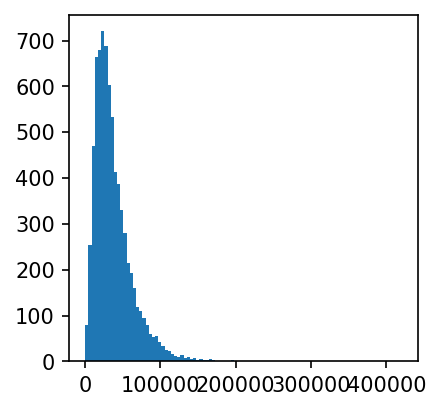

In [32]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(df['num_aligned'], bins=100);

##### What is the average Coefficient Variation?

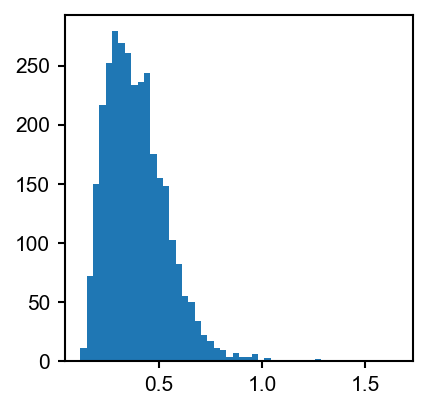

In [31]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())

fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(data, bins=50)
publication_style_ax(ax)


In [33]:
np.mean(data)

0.3942839835926987

##### individual measurements to std 

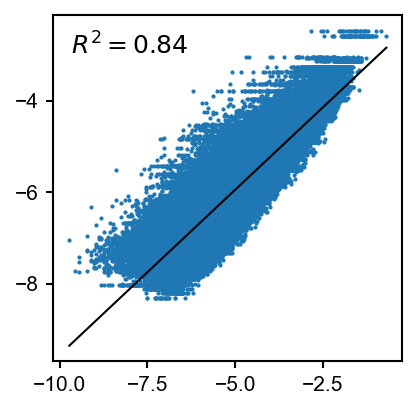

In [38]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row['r_data'] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])   
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(3, 3))
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
publication_style_ax(ax)

### DMS reactivity values are continuous, and a significant overlap exists between Watson-Crick and non-canonical interactions.